## 分析A/B测试结果


## 目录
- [简介](#intro)
- [I - 概率](#probability)
- [II - A/B 测试](#ab_test)
- [III - 回归](#regression)


<a id='intro'></a>
### 简介

通常情况下，A/B 测试由数据分析师和数据科学家来完成。

对于这个项目，我将要了解的是电子商务网站运行的 A/B 测试的结果。我的目标是通过这个 notebook 来帮助公司弄清楚他们是否应该使用新的页面，保留旧的页面，或者应该将测试时间延长，之后再做出决定。

<a id='probability'></a>
#### I - 概率

让我们先导入库，然后开始任务吧。

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` 现在，导入 `ab_data.csv` 数据，并将其存储在 `df` 中。  

a. 导入数据集，并在这里查看前几行：

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. 使用下面的单元格来查找数据集中的行数。

In [3]:
df.shape[0]

294478

c. 数据集中独立用户的数量。

In [4]:
df['user_id'].nunique()

290584

d. 用户转化的比例。

In [5]:
df['converted'].sum()/df['user_id'].nunique()

0.12126269856564711

e.  `new_page` 与 `treatment` 不一致的次数。

In [6]:
print(df[(df['landing_page']!='new_page')&(df['group']=='treatment')].shape[0])
print(df[(df['landing_page']=='new_page')&(df['group']!='treatment')].shape[0])

1965
1928



f. 是否有任何行存在缺失值？

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` 对于 **treatment** 不与 **new_page** 一致的行或 **control** 不与 **old_page** 一致的行，我们不能确定该行是否真正接收到了新的或旧的页面。我们删除这些行，不使用这些混乱数据。 

a. 现在，使用测试题的答案创建一个符合测试规格要求的新数据集。将新 dataframe 存储在 **df2** 中。

In [8]:
good_match = df[(df['group'] == 'treatment')&(df['landing_page'] == 'new_page')].shape[0]
bad_match = df[(df['landing_page']!='new_page')&(df['group']=='treatment')].shape[0] + df[(df['landing_page']=='new_page')&(df['group']!='treatment')].shape[0]
print(bad_match/good_match)

df2 = df[(df['group'] == 'treatment')&(df['landing_page'] == 'new_page') | (df['group'] == 'control')&(df['landing_page'] == 'old_page')]
print(df2.shape[0])

0.026790814184748574
290585


In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` 查看更新后的数据集 。

a.  **df2** 中有多少唯一的 **user_id**?

In [10]:
df2['user_id'].nunique()

290584

b.  **df2** 中有一个重复的 **user_id** 。它是什么？ 

In [11]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. 这个重复的  **user_id** 的行信息是什么？

index：2893

d. 删除 **一个** 含有重复的 **user_id** 的行， 但需要确保你的 dataframe 为 **df2**。

In [12]:
df2 = df2.drop_duplicates(['user_id'])
df2.shape[0]

290584

`4.` 概率分析。

a. 不管它们收到什么页面，单个用户的转化率是多少？


In [13]:
df2['converted'].sum() / df2.shape[0]

0.11959708724499628

b. 假定一个用户处于 `control` 组中，他的转化率是多少？

In [14]:
df2[df2['group'] == 'control']['converted'].sum() / df2[df2['group'] == 'control'].shape[0]

0.1203863045004612

c. 假定一个用户处于 `treatment` 组中，他的转化率是多少？


In [15]:
df2[df2['group'] == 'treatment']['converted'].sum() / df2[df2['group'] == 'treatment'].shape[0]

0.11880806551510564

d. 一个用户收到新页面的概率是多少？


In [16]:
df2[df2['landing_page'] == 'new_page'].shape[0] / df2.shape[0]

0.5000619442226688

e. 使用这个问题的前两部分的结果，给出你的建议：你是否认为有证据表明一个页面可以带来更多的转化？在下面写出你的答案。

**我不认为有证据表明一个页面可以带来更多的转化。**

<a id='ab_test'></a>
### II - A/B 测试



`1.` 现在，我要考虑的是，我需要根据提供的所有数据做出决定。如果我想假定旧的页面效果更好，除非新的页面在类型I错误率为5％的情况下才能证明效果更好，那么，我的零假设和备择假设是什么？ 

$ H_0:p_{new}−p_{old} \leq 0 $

$ H_1:p_{new}−p_{old}>0 $

`2.` 假定在零假设中，不管是新页面还是旧页面， $p_{new}$ and $p_{old}$ 都具有等于 **转化** 成功率的“真”成功率，也就是说，  $p_{new}$ 与 $p_{old}$ 是相等的。此外，假设它们都等于**ab_data.csv** 中的 **转化** 率，新旧页面都是如此。  <br>

每个页面的样本大小要与 **ab_data.csv** 中的页面大小相同。  <br>

执行两次页面之间 **转化** 差异的抽样分布，计算零假设中10000次迭代计算的估计值。  <br>


a. 在零假设中，$p_{new}$ 的 **convert rate（转化率）** 是多少？


In [17]:
p_new = df2.converted.mean()
round(p_new, 4)

0.1196

b. 在零假设中， $p_{old}$  的 **convert rate（转化率）** 是多少？ <br><br>

In [18]:
p_old = p_new
round(p_old, 4)

0.1196

c.  $n_{new}$ 是多少？

In [19]:
df2[df2['landing_page'] == 'new_page'].shape[0]

145310

d.  $n_{old}$?是多少？

In [20]:
df2[df2['landing_page'] == 'old_page'].shape[0]

145274

e. 在零假设中，使用 $p_{new}$ 转化率模拟 $n_{new}$ 交易，并将这些模拟值存储在 **new_page_converted** 中。

In [21]:
new_page_converted = np.random.choice([0, 1],145310, p = [1-p_new,p_new])
new_page_conr = round(new_page_converted.mean(),6)
new_page_conr

0.119916

f. 在零假设中，使用 $p_{old}$ 转化率模拟 $n_{old}$ 交易。

In [22]:
old_page_converted = np.random.choice([0, 1],145274, p = [1-p_old,p_old])
old_page_conr = round(old_page_converted.mean(),6)
old_page_conr

0.119361

g. 在 (e) 与 (f)中找到 $p_{new}$ - $p_{old}$ 模拟值。

In [23]:
p_compare = new_page_conr - old_page_conr
p_compare

0.0005549999999999999

h. 使用a. 到 g. 中的计算方法来模拟 10,000个 $p_{new}$ - $p_{old}$ 值，并将这 10,000 个值存储在 **p_diffs** 中。

In [24]:
p_diffs = []
for i in range(1000):
    new_page_converted = np.random.choice([0, 1],145310, p = [1-p_new,p_new])
    old_page_converted = np.random.choice([0, 1],145274, p = [1-p_old,p_old])
    p_diffs.append(new_page_converted.mean()-old_page_converted.mean())
    
p_diffs = np.array(p_diffs)
type(p_diffs)
# 将上面的代码循环1万遍，得出这1万遍模拟新旧转化率的差异

numpy.ndarray

i. 绘制一个 **p_diffs** 直方图。

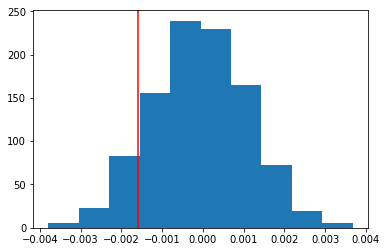

In [25]:
obs_diff = df2.query('landing_page == "new_page"')['converted'].mean() - df2.query('landing_page == "old_page"')['converted'].mean()

plt.hist(p_diffs)
plt.axvline(x = obs_diff, color = 'red');

j.  在**p_diffs**列表的数值中，有多大比例大于 **ab_data.csv** 中观察到的实际差值？

In [26]:
(p_diffs > obs_diff).mean()

0.893


**计算出的结果为p值，它大于第一类错误率0.05，所以无法拒绝零假设。新旧页面的转化率无区别。**


<a id='regression'></a>
### III - 回归分析法之一

`1.` 我在之前的A / B测试中获得的结果也可以通过执行回归来获取。<br><br>

a. 既然每行的值是转化或不转化，那么在这种情况下，我应该执行逻辑回归。


**在 AB 测试中需要根据试验组和对照组数据分析试验结果是否具有显著性——这与逻辑回归分析成功与否的二分类问题相同。使用 AB 测试的数据，通过构建逻辑回归模型来分析解释变量对 AB 测试结果的影响。**

b. 使用 **statsmodels** 来拟合在 **a.** 中指定的回归模型，以查看用户收到的不同页面是否存在显著的转化差异。首先，需要为这个截距创建一个列，并为每个用户收到的页面创建一个虚拟变量列。添加一个 **截距** 列，一个 **ab_page** 列，当用户接收 **treatment** 时为1， **control** 时为0。

In [27]:
df2['intercept'] = 1
df2[['new_page','old_page']] = pd.get_dummies(df2['landing_page'])
df2['ab_page'] = df['group'].map(lambda x:1 if x=="treatment" else 0)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0



c. 使用 **statsmodels** 导入回归模型。 实例化该模型，并使用在 **b.** 中创建的2个列来拟合该模型，用来预测一个用户是否会发生转化。

In [28]:
import statsmodels.api as sm
logit_mod = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. 提供模型摘要

In [29]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Apr 2019   Pseudo R-squ.:               8.077e-06
Time:                        02:15:37   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. 与 **ab_page** 关联的 p-值是多少？ 

**与ab_page关联的p_值是0.190，与II 中的p_值不同。II 中的p_值计算是单尾的，而此处p值计算是双尾的（回归模型摘要的结果里是P>|z|）。**



f. 现在考虑其他可能影响用户是否发生转化的因素。

**在回归模型中添加更多因素会带来更准确的训练结果，但是太多了的话，结果会只对样本很管用（欠拟合），对新的数据就不那么适用了（过拟合）。**

g. 现在，除了测试不同页面的转化率是否会发生变化之外，还要根据用户居住的国家或地区添加一个 effect 项。导入 **countries.csv** 数据集，并将数据集合并在适当的行上。


In [30]:
country = pd.read_csv('countries.csv')
df3 = df2.join(country.set_index('user_id'), on='user_id')
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,US


In [31]:
df3[['CA','UK','US']] = pd.get_dummies(df3['country'])
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,US,0,0,1


In [32]:
df3['intercept'] = 1
lm = sm.Logit(df3['converted'],df3[['intercept','CA','UK']])
result_country = lm.fit()
result_country.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 22 Apr 2019   Pseudo R-squ.:               1.521e-05
Time:                        02:15:39   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

h. 现在已经查看了国家与页面在转化率上的个体性因素，但现在我们要查看页面与国家/地区之间的相互作用，测试其是否会对转化产生重大影响。创建必要的附加列，并拟合一个新的模型。  


In [33]:
df3['new_CA'] = df3['new_page'] * df3['CA']
df3['new_UK'] = df3['new_page'] * df3['UK']
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country,CA,UK,US,new_CA,new_UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US,0,0,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,US,0,0,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,US,0,0,1,0,0


In [34]:
lm = sm.Logit(df3['converted'],df3[['intercept','ab_page','UK','CA','new_UK','new_CA']])
result_new_country = lm.fit()
result_new_country.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 22 Apr 2019   Pseudo R-squ.:               3.482e-05
Time:                        02:15:40   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
new_UK         0.0314      0.027      1.181      0.238      -0.021       0.084
new_CA        -0.0469      0.054     -0.872      0.383      -0.152       0.059
==============================================================================
"""

**p值都大于0.05，所以和前面结论一致，我们不能拒绝零假设（ $p_{old}  =  p_{new}$）。**

## 结论

**根据我们的A / B测试结果，不推荐这家电商发布新页面**